In [1]:
import os
import sys
import cv2
import glob
import random
import shutil
import pandas as pd
import matplotlib.pyplot as plt

# fastai stuff
import fastbook
fastbook.setup_book()
import timm
from fastai.vision.all import *
from fastbook import *
from fastai.vision.widgets import *

In [39]:
# center the matplotlib plots to the middle of the notebook
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### See which categories we have in the dataset and how many images in each category

In [19]:
data_path = "./data/"
categories = [cat for cat in os.listdir(data_path) if cat[0] in ['F', 'R']]

In [4]:
category_sizes = {c:len(glob.glob(os.path.join(data_path, c, "*.jpg"))) for c in categories}
category_sizes = dict(sorted(category_sizes.items(), key=lambda x: x[0]))  # sort the dictionary by keys
category_names = sorted(list({name.replace("Fresh", "").replace("Rotten", "") for name in category_sizes.keys()}))

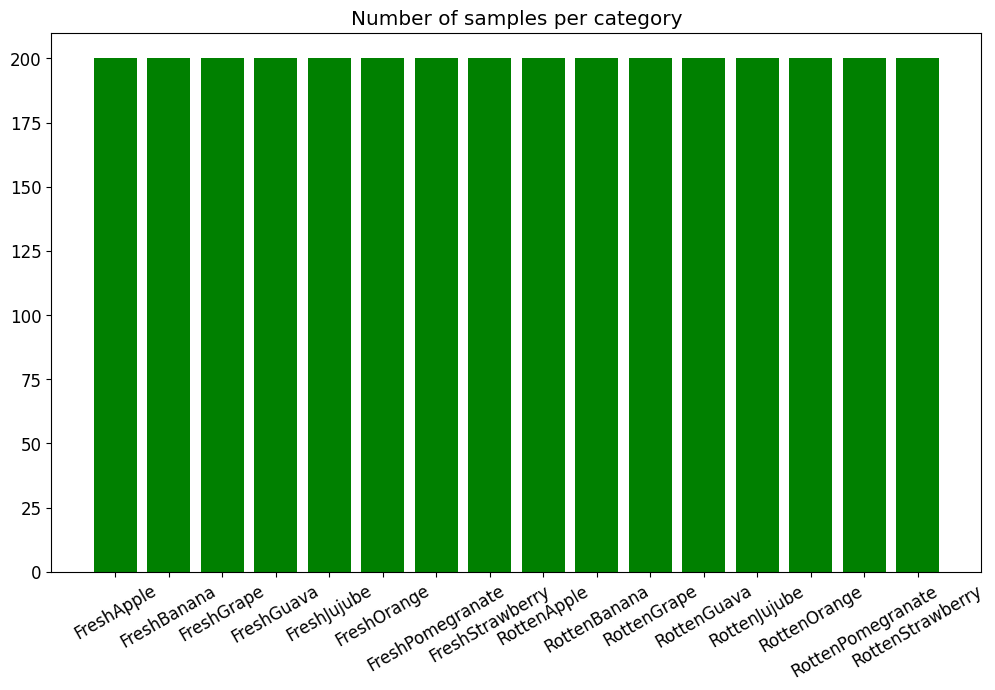

In [5]:
plt.figure(figsize=(12, 7))
plt.bar(category_sizes.keys(), category_sizes.values(), color='g')
plt.xticks(rotation=30)
plt.title("Number of samples per category")
plt.show()

### Visualize a few images from each category

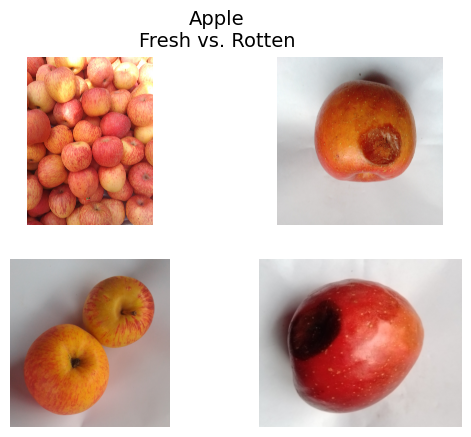

---------------------------------------------------------------------------------------------------------------------


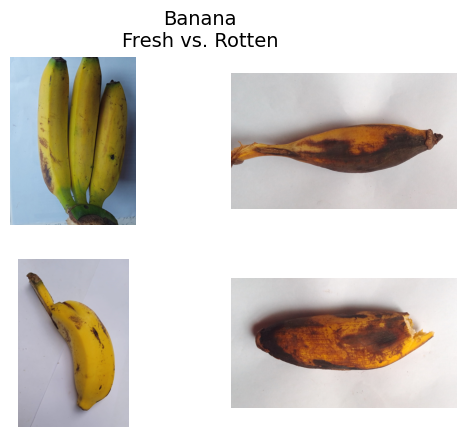

---------------------------------------------------------------------------------------------------------------------


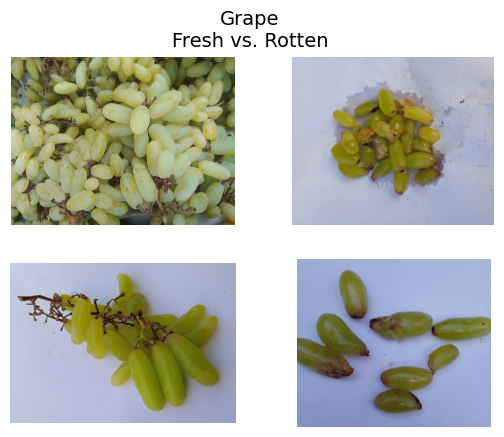

---------------------------------------------------------------------------------------------------------------------


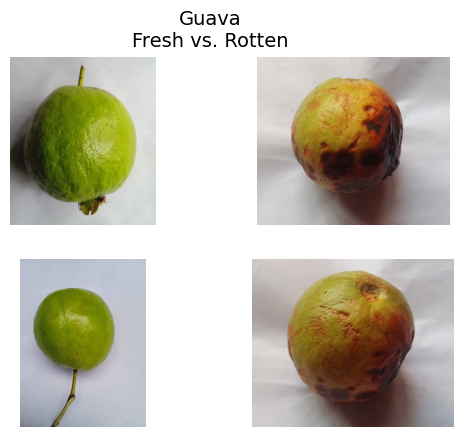

---------------------------------------------------------------------------------------------------------------------


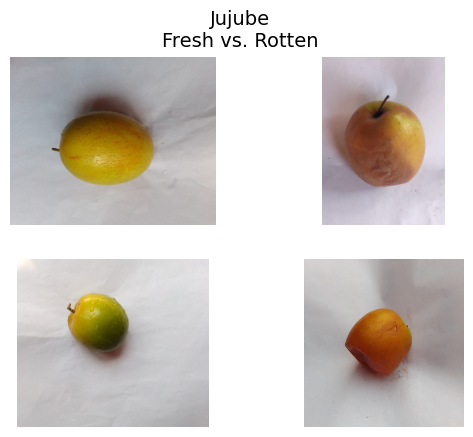

---------------------------------------------------------------------------------------------------------------------


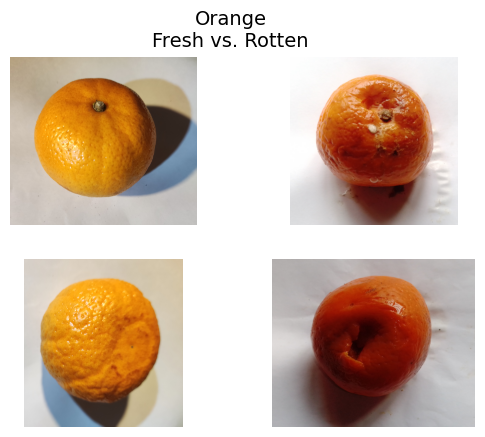

---------------------------------------------------------------------------------------------------------------------


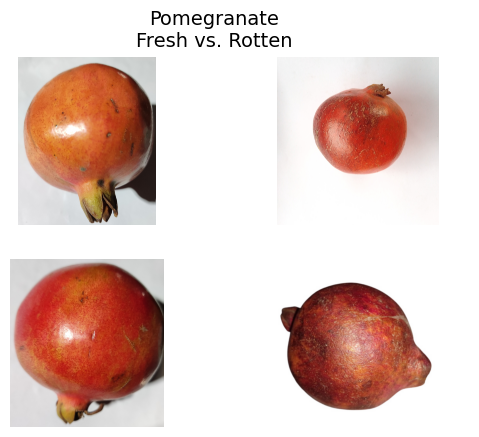

---------------------------------------------------------------------------------------------------------------------


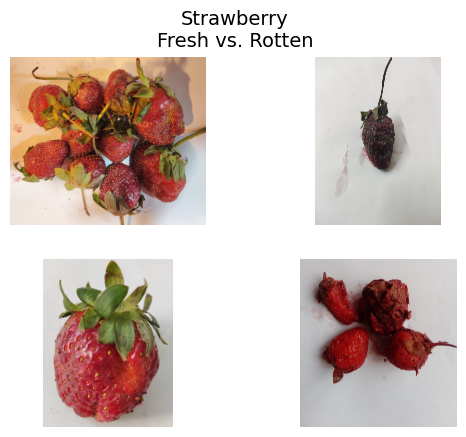

---------------------------------------------------------------------------------------------------------------------


In [10]:
# For each fruit:
#    - create 4 subplots
#    - on the 2 plots on the left: plot fresh examples of the fruit
#    - on the 2 plots on the right: plot rotten examples of the fruit

for category_name in category_names:
    fresh_version_name = "Fresh" + category_name
    rotten_version_name = "Rotten" + category_name
    
    fresh_fruits_paths = glob.glob(os.path.join(data_path, fresh_version_name, "*.jpg"))
    rotten_fruits_paths = glob.glob(os.path.join(data_path, rotten_version_name, "*.jpg"))
    
    fresh_fruits_sample = random.sample(fresh_fruits_paths, k=2)
    rotten_fruits_sample = random.sample(rotten_fruits_paths, k=2)
    
    fresh_fruits = [cv2.cvtColor(cv2.imread(t), cv2.COLOR_BGR2RGB) for t in fresh_fruits_sample]
    rotten_fruits = [cv2.cvtColor(cv2.imread(t), cv2.COLOR_BGR2RGB) for t in rotten_fruits_sample]
    
    fig = plt.gcf()
    fig.suptitle(f"{category_name}\nFresh vs. Rotten", fontsize=14)
    
    plt.subplot(2, 2, 1)
    plt.imshow(fresh_fruits[0])
    plt.axis("off")
    
    plt.subplot(2, 2, 3)
    plt.imshow(fresh_fruits[1])
    plt.axis("off")
    
    plt.subplot(2, 2, 2)
    plt.imshow(rotten_fruits[0])
    plt.axis("off")
    
    plt.subplot(2, 2, 4)
    plt.imshow(rotten_fruits[1])
    plt.axis("off")
    
    plt.show()
    print('-' * 117)

### Create a stratified train/valid/test split

`- 200 images for each category`

`- use a 70/15/15 split`

`=> 140/30/30 images from each category of <status><fruit> (e.g., FreshApple, RottenBanana)`

We will use the images in the following file format (ImageNet-like):

/data 

     /train
           /fresh
           /rotten
     /valid
           /fresh
           /rotten
     /test     
          /fresh
          /rotten

In [33]:
TRAIN_SIZE = 140
VALID_SIZE = 30
TEST_SIZE = 30

train_set_path = os.path.join(data_path, "train")
valid_set_path = os.path.join(data_path, "valid")
test_set_path = os.path.join(data_path, "test")
set_paths = [train_set_path, valid_set_path, test_set_path]

for category in categories:
    path = os.path.join(data_path, category)
    images = glob.glob(os.path.join(path, "*.jpg"))
    random.shuffle(images)  # shuffle the images to get rid of any potential file patterns
    
    to_train = images[:TRAIN_SIZE]
    to_valid = images[TRAIN_SIZE:TRAIN_SIZE + VALID_SIZE]
    to_test = images[TRAIN_SIZE + VALID_SIZE:]
    
    for set_path, new_set_files in zip(set_paths, [to_train, to_valid, to_test]):
        copy_to = os.path.join(set_path, "fresh") if 'Fresh' in category else os.path.join(set_path, "rotten")
        for file in new_set_files:
            file_name = os.path.basename(file)
            new_path = os.path.join(copy_to, file_name)
            shutil.copy2(file, new_path)

### Load the data into dataloaders and apply various augmentations

In [17]:
dls = ImageDataLoaders.from_folder("./data/", 
                                   item_tfms=Resize(500),
                                   batch_tfms=[*aug_transforms(size=224, 
                                                               flip_vert=True, 
                                                               max_rotate=30.0, 
                                                               max_lighting=0.6,
                                                               max_warp=0.4, 
                                                               max_zoom=1.3, 
                                                               min_scale=0.75), 
                                               Normalize.from_stats(*imagenet_stats)], 
                                   bs=32)

### See how the augmented data looks

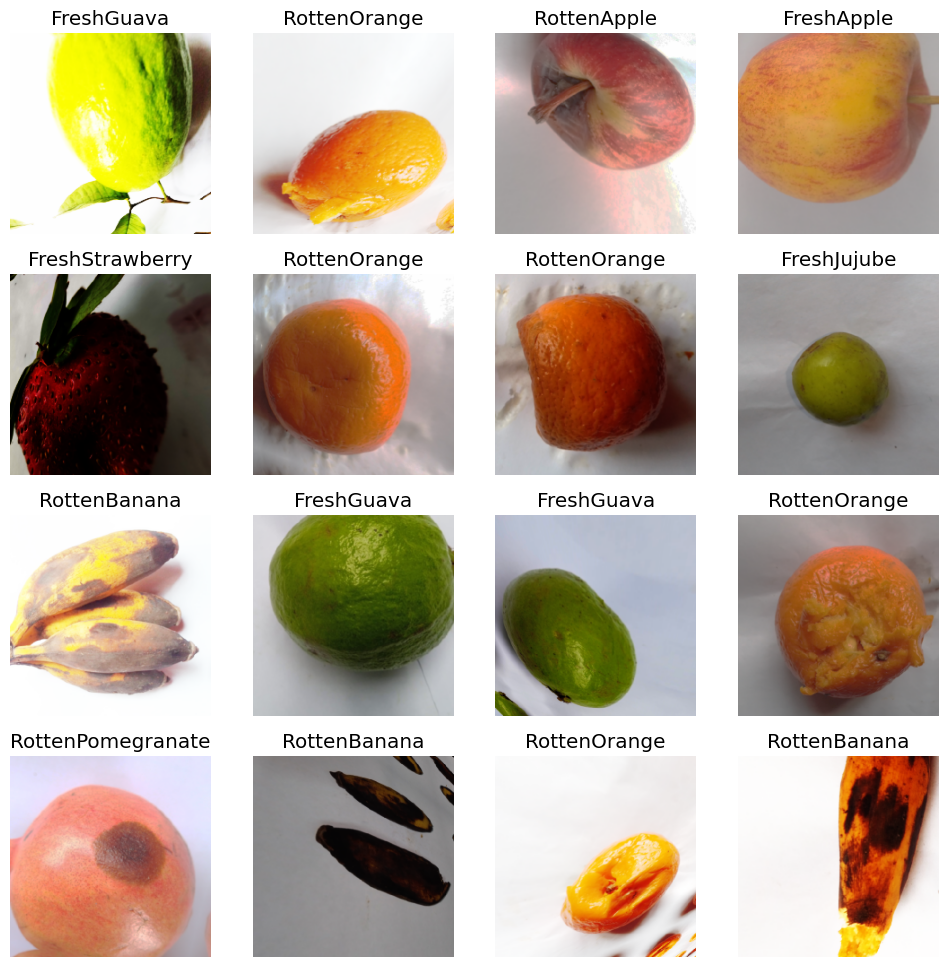

In [18]:
dls.show_batch(max_n=16)

### See how one image is transformed when apply various augmentations
#### So below we have multiple variations of the same unique image. The variations are created by applying augmentations

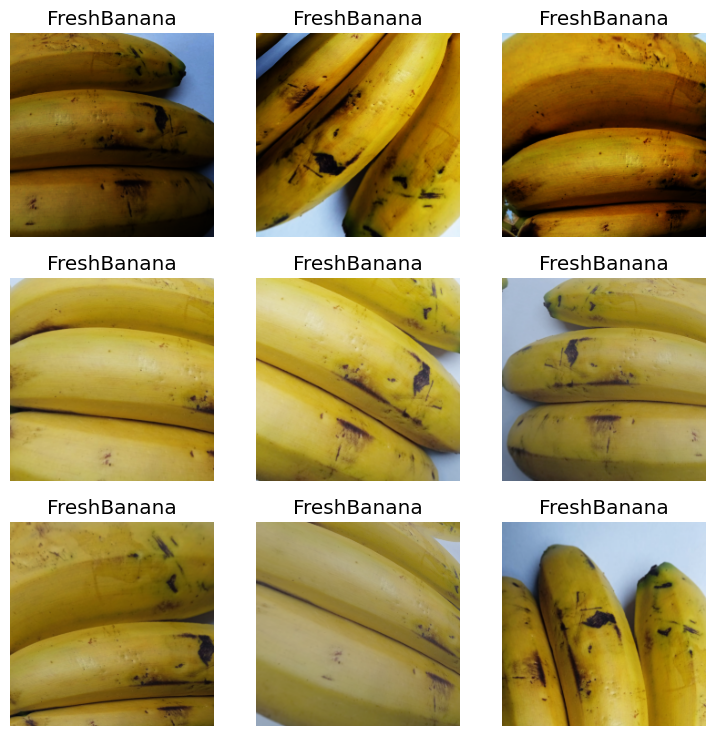

In [19]:
dls.show_batch(unique=True)

### Model

In [4]:
dls = ImageDataLoaders.from_folder(data_path,
                                   item_tfms=Resize(400),
                                   batch_tfms=[*aug_transforms(size=224,
                                                               max_rotate=10.0), 
                                               Normalize.from_stats(*imagenet_stats)], 
                                   bs=32, 
                                   device="cuda")

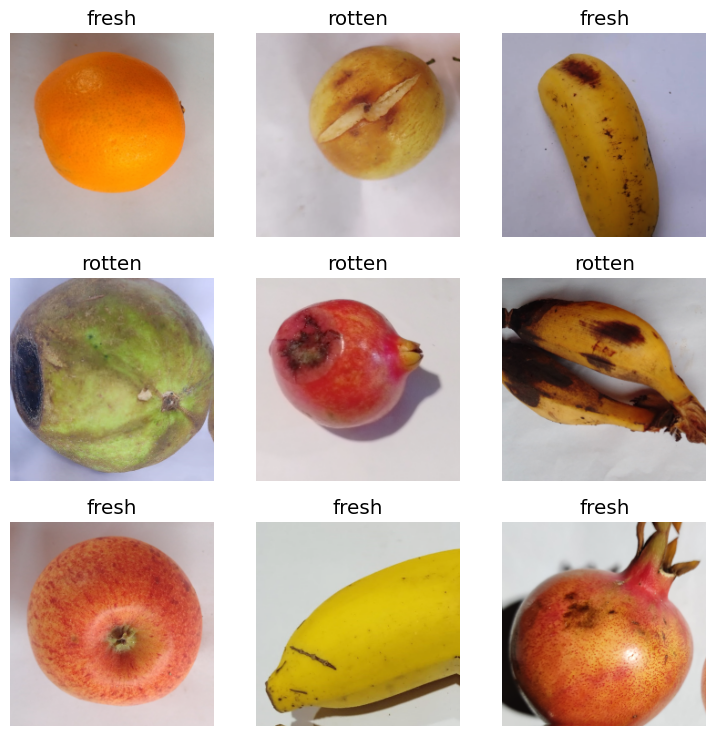

In [5]:
dls.show_batch()

In [9]:
learn = vision_learner(dls, "convnext_tiny_in22k", loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(valley=0.0005754399462603033)

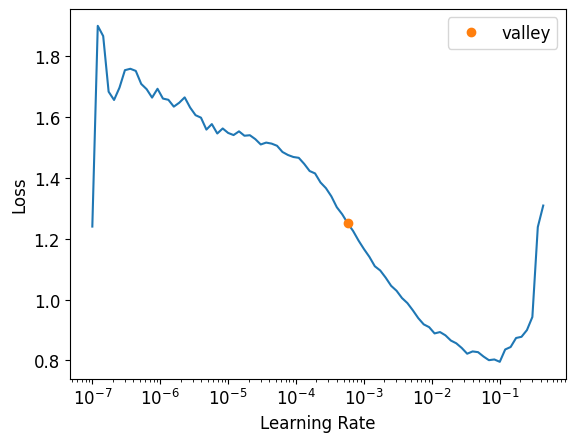

In [10]:
learn.lr_find()

In [11]:
learn.fine_tune(10, 1e-3)

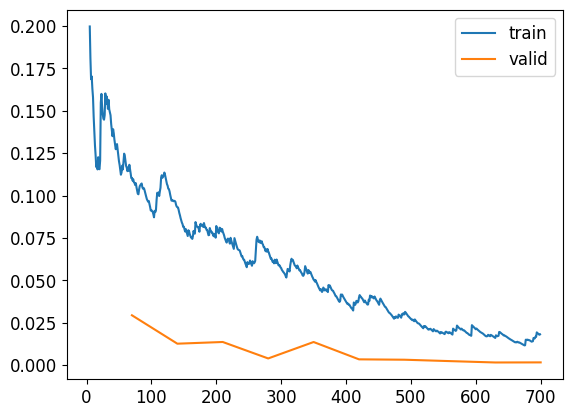

In [12]:
learn.recorder.plot_loss()

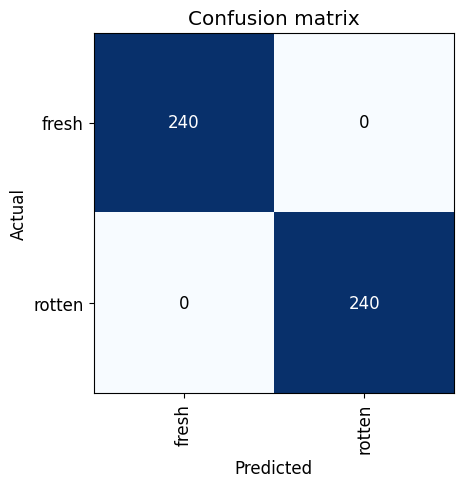

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

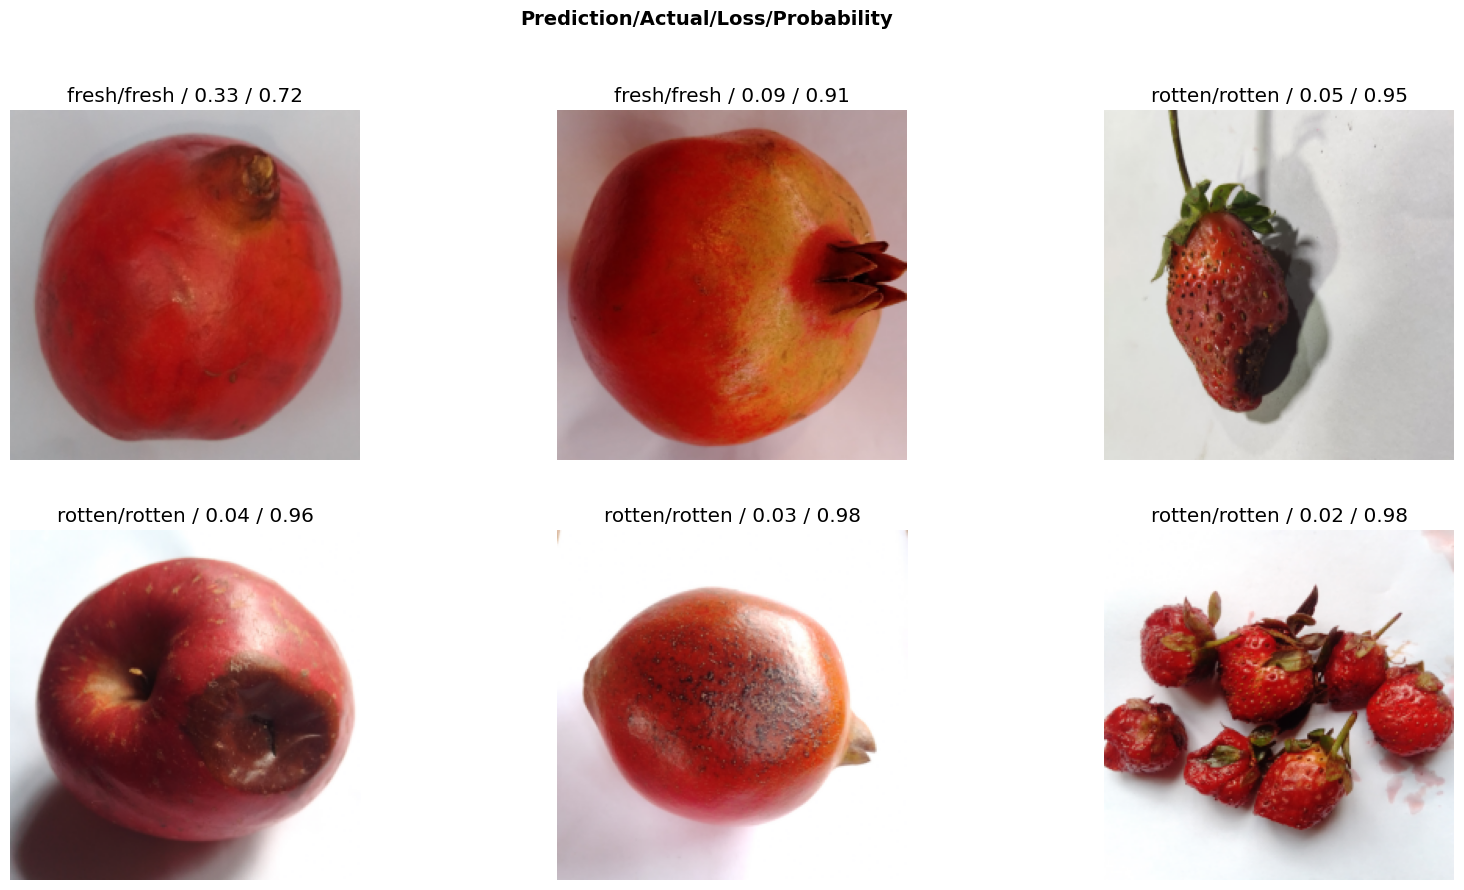

In [17]:
interp.plot_top_losses(6, nrows=2, figsize=(20, 10))

### Test set

In [42]:
test_dir_path = "./data/test/"
test_files = [fn for fn in glob.glob(os.path.join(test_dir_path, "**/*.jpg"), recursive=True)]
test_dl = learn.dls.test_dl(test_files)

In [50]:
preds, _, decoded = learn.get_preds(dl=test_dl, with_decoded=True)

In [68]:
tp, fp, tn, fn = 0, 0, 0, 0

for predicted_class, file_name in zip(decoded, test_files):
    if "fresh" in file_name:
        if predicted_class.item() == 0:
            tn += 1
        else:
            fp += 1
    else:
        if predicted_class.item() == 0:
            fn += 1
        else:
            tp += 1

In [70]:
acc = (tp + tn) / (tp + fp + tn + fn)
prec = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"TEST SET ACCURACY: {acc}")
print(f"TEST SET PRECISION: {prec}")
print(f"TEST SET RECALL: {recall}")

TEST SET ACCURACY: 1.0
TEST SET PRECISION: 1.0
TEST SET RECALL: 1.0
